# Model- vs. Epoch-wise Double Descent

In [61]:
import numpy as np
import pandas as pd
import torch

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import seaborn as sns

import os

if os.getenv('USE_TQDM_NOTEBOOK', 'NO').lower() in ['yes', 'true', '1'
                ]:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

# Linear Regression

Varying the sample size / input size

/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.10564e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=3.19163e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/Jesse/Projects/pattern-le

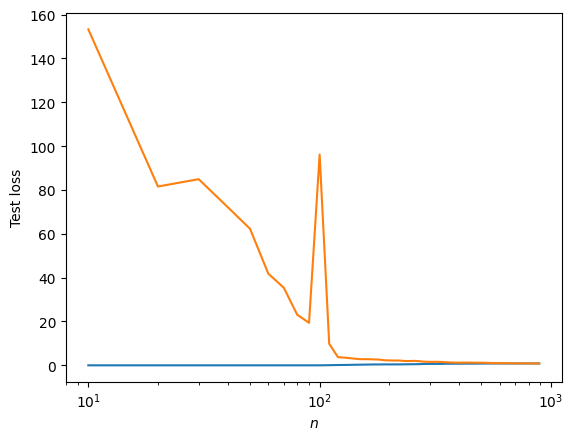

In [66]:
# First let's demonstrate DD in a simple linear regression setting

def swdd_linreg(num_params=100, num_samples=1000, samples_range=(10, 900), seed=42):
    """Demonstrate sample-wise double descent for linear regression."""

    # Let's generate some data
    np.random.seed(seed)
    X = np.random.normal(size=(num_samples, num_params))
    W = np.random.normal(size=(num_params, 1))
    y = (W.T @ X.T + np.random.normal(size=(1, num_samples))).reshape(-1)

    # Let's fit a linear regression model

    def fit_model(X, y):
        model = Ridge(alpha=0.00)
        model.fit(X, y)
        return model

    # Sweep over subsets of the data
    train_loss = []
    test_loss = []
    sample_sizes = [int(s) for s in np.arange(*samples_range, 10)]

    for sample_size in sample_sizes:
        model = fit_model(X[:sample_size], y[:sample_size])
        train_loss.append(np.mean((model.predict(X[:sample_size]) - y[:sample_size]) ** 2))
        test_loss.append(np.mean((model.predict(X[num_samples - sample_size :]) - y[num_samples - sample_size :]) ** 2))

    # Plot the results
    return sample_sizes, train_loss, test_loss

sample_sizes, train_loss, test_loss = swdd_linreg()
plt.plot(sample_sizes, train_loss, label="train")
plt.plot(sample_sizes, test_loss, label="test")
# plt.legend()
plt.xscale("log")

plt.xlabel("$n$")
plt.ylabel("Test loss")
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

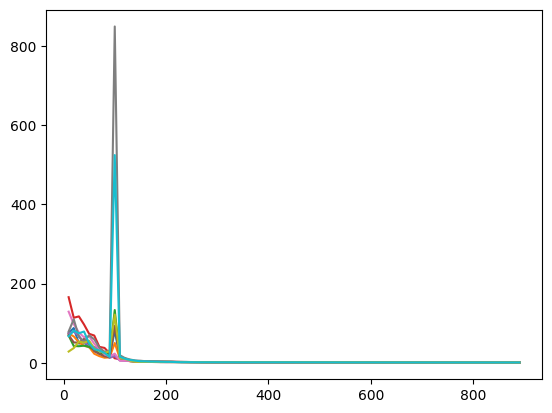

In [43]:
# Let's average over a few trials

def swdd_linreg_multiple(num_params=100, num_samples=1000, samples_range=(10, 900), num_trials=10):
    """Demonstrate sample-wise double descent for linear regression & average over multiple trials."""
    
    sample_sizes, train_loss, test_loss = swdd_linreg(num_params, num_samples, samples_range, seed=0)

    train_losses = np.zeros((num_trials, len(sample_sizes)))
    test_losses = np.zeros((num_trials, len(sample_sizes)))

    train_losses[0, :] = train_loss
    test_losses[0, :] = test_loss

    for i in tqdm(range(1, num_trials)):
        _, train_loss, test_loss = swdd_linreg(num_params, num_samples, samples_range, seed=i)
        train_losses[i] = train_loss
        test_losses[i] = test_loss

    # for i in range(num_trials):
    #     plt.plot(sample_sizes, test_losses[i], label="test")
    # 
    # plt.show()

    train_loss_means = np.mean(train_losses, axis=0)
    train_loss_stds = np.std(train_losses, axis=0)

    test_loss_means = np.mean(test_losses, axis=0)
    test_loss_stds = np.std(test_losses, axis=0)

    return sample_sizes, train_loss_means, train_loss_stds, test_loss_means, test_loss_stds

sample_sizes, train_loss_means, train_loss_stds, test_loss_means, test_loss_stds = swdd_linreg_multiple()

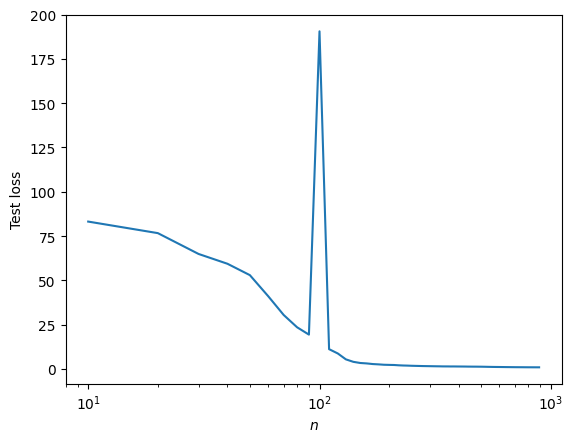

In [44]:
# The height of the peak is distributed according to something like an exponential distribution, so the std is not very meaningful 

# plt.plot(sample_sizes, train_loss_means, label="train")
# plt.fill_between(sample_sizes, train_loss_means - train_loss_stds, train_loss_means + train_loss_stds, alpha=0.2)
plt.plot(sample_sizes, test_loss_means, label="test")
# plt.fill_between(sample_sizes, test_loss_means - 1.96 * test_loss_stds, test_loss_means + 1.96 * test_loss_stds, alpha=0.2)
plt.xscale("log")
plt.xlabel("$n$")
plt.ylabel("Test loss")
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

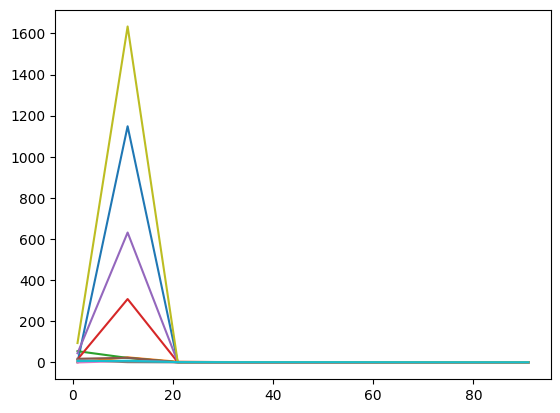

  0%|          | 0/9 [00:00<?, ?it/s]

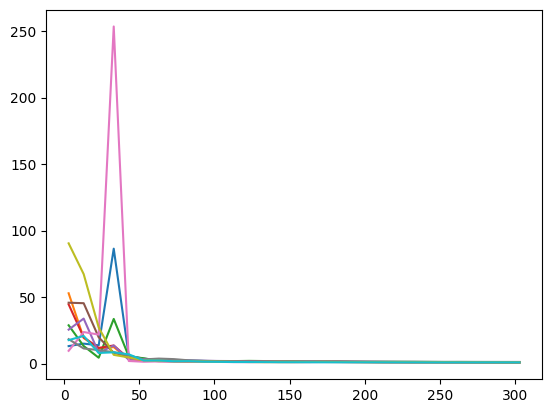

  0%|          | 0/9 [00:00<?, ?it/s]

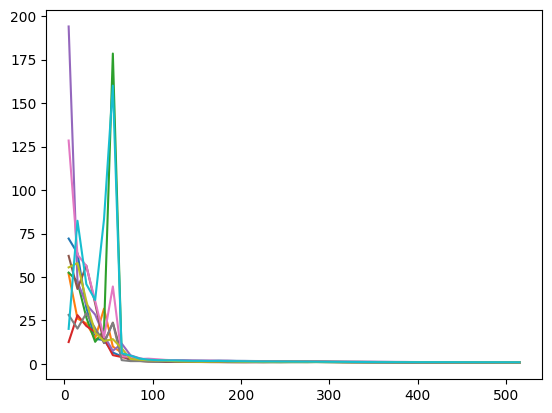

  0%|          | 0/9 [00:00<?, ?it/s]

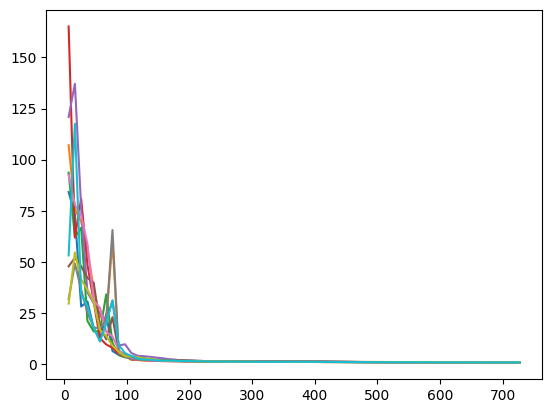

  0%|          | 0/9 [00:00<?, ?it/s]

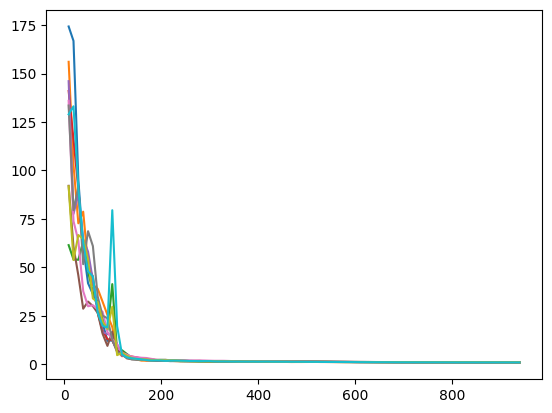

  0%|          | 0/9 [00:00<?, ?it/s]

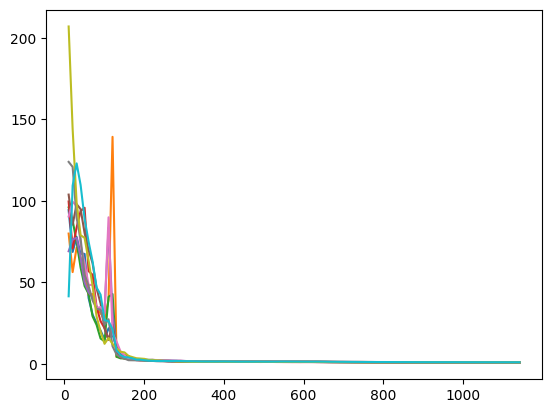

  0%|          | 0/9 [00:00<?, ?it/s]

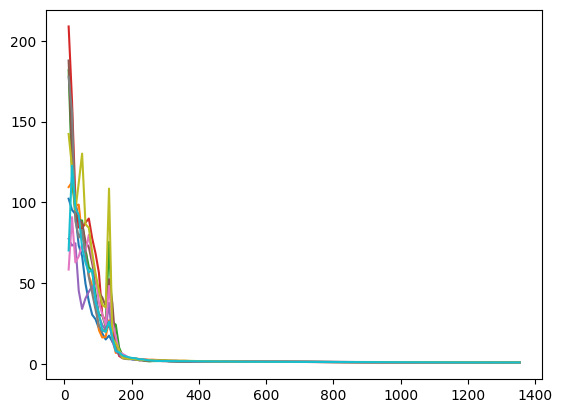

  0%|          | 0/9 [00:00<?, ?it/s]

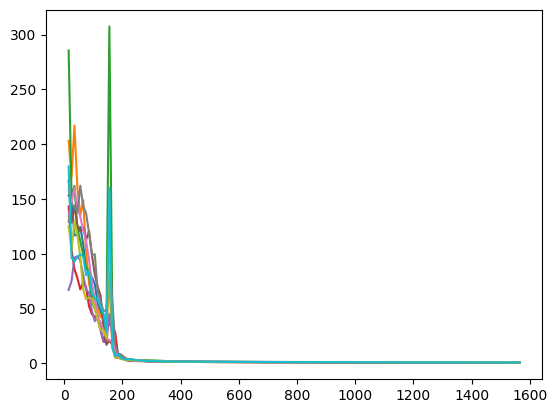

  0%|          | 0/9 [00:00<?, ?it/s]

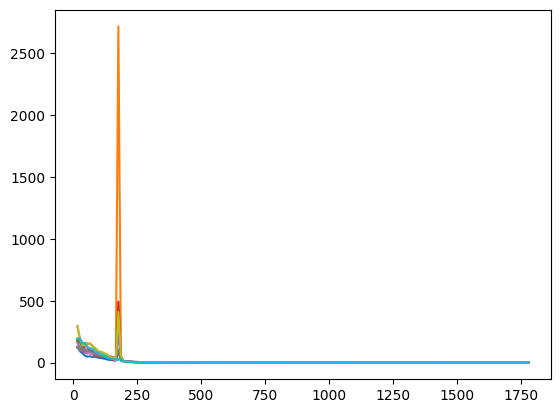

  0%|          | 0/9 [00:00<?, ?it/s]

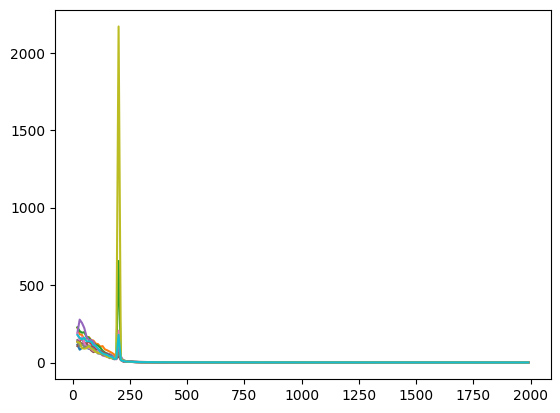

In [46]:
def scale_free_swdd_linreg(param_range=(10, 200), num_entries=10, num_trials=10):
    """Demonstrate double descent in terms of the fraction of samples to parameters."""

    df = pd.DataFrame(columns=["num_params", "sample_fraction", "train_loss", "test_loss"])

    params = np.array([int(p) for p in np.linspace(*param_range, num_entries)])
    
    for param in tqdm(params):
        min_, max_, num_samples = param * 0.1, param * 10, param * 11
        sample_sizes, train_loss_means, train_loss_stds, test_loss_means, test_loss_stds = swdd_linreg_multiple(num_params=param, num_samples=num_samples, samples_range=(min_, max_), num_trials=num_trials)
        sample_fractions = sample_sizes / param

        df = pd.concat(
            [df,
            pd.DataFrame(
                {
                    "num_params": param,
                    "sample_fraction": sample_fractions,
                    "train_loss": train_loss_means,
                    "test_loss": test_loss_means,
                    "train_loss_errbar": 1.96 * train_loss_stds,
                    "test_loss_errbar": 1.96 * test_loss_stds,
                }
            )
            ]
        )

    return df

df = scale_free_swdd_linreg()

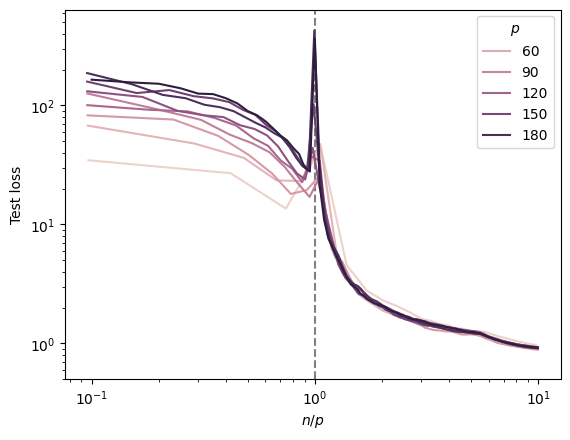

In [59]:
# Get rid of num_params <= 10
df = df[df["num_params"] > 10] 

plt.vlines(1, 0.5, df.loc[:, "test_loss"].max() * 1.5, linestyles="dashed", color="grey")
sns.lineplot(data=df, x="sample_fraction", y="test_loss", hue="num_params")

plt.legend(title="$p$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$n/p$")
plt.ylabel("Test loss")
plt.ylim(0.5, df.loc[:, "test_loss"].max() * 1.5)
plt.show()

The above figure demonstrates that double descent in the case of linear regression is a proper phase transition. If we take the limit of $p,n \to \infty$ while holding $p/n$ constant, the double descent loss peak will diverge

# Polynomial Regression

Varying the degree of a polynomial (rather than input size/sample size)

  0%|          | 0/290 [00:00<?, ?it/s]

/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/numpy/polynomial/legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)
/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_44268/818254499.py:31: RuntimeWarning: overflow encountered in square
  test_loss.append(np.mean((model(X[num_samples:]) - y[num_samples:]) ** 2))
/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/Jesse/Projects/pattern-learning/.venv/lib/python3.10/site-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


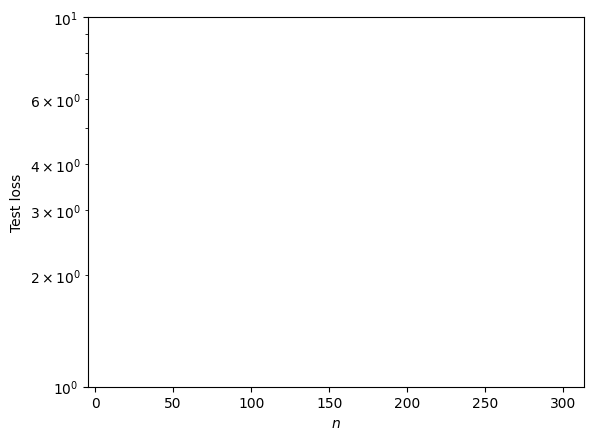

In [76]:
# First let's demonstrate DD in a simple linear regression setting
from numpy.polynomial.legendre import Legendre

def dwdd_polyreg(num_samples=100, degrees_range=(10, 300), deg=50, seed=42, epsilon=0.1):
    """Demonstrate degree-wise double descent for polynomial regression.
    
    Uses Legendre polynomials (so the range is reasonable)
    """

    # Let's generate some data
    np.random.seed(seed)
    X = np.linspace(-1, 1, num_samples * 2) #np.random.normal(size=(num_samples * 2)
    coef = np.random.normal(size=(deg))
    fn = Legendre(coef=coef)
    y = fn(X) + epsilon * np.random.normal(size=(num_samples * 2))

    # Let's fit a linear regression model

    def fit_model(X, y, deg):
        model = Legendre.fit(X, y, deg=deg)
        return model

    # Sweep over subsets of the data
    train_loss = []
    test_loss = []
    degrees = [int(s) for s in np.arange(*degrees_range, 1)]

    for _deg in tqdm(degrees):
        model = fit_model(X[:num_samples], y[:num_samples], _deg)
        train_loss.append(np.mean((model(X[:num_samples]) - y[:num_samples]) ** 2))
        test_loss.append(np.mean((model(X[num_samples:]) - y[num_samples:]) ** 2))

    # Plot the results
    return degrees, train_loss, test_loss

degrees, train_loss, test_loss = dwdd_polyreg()
plt.plot(degrees, train_loss, label="train")
plt.plot(degrees, test_loss, label="test")
# plt.legend()
# plt.xscale("log")
plt.yscale("log")

plt.xlabel("$n$")
plt.ylabel("Test loss")
plt.show()